# RoBERTa

In [1]:
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
from io import StringIO
import json
import pickle
import matplotlib.pyplot as plt
import re

In [2]:
# !unzip datasets.zip

In [3]:
from transformers import (
    Trainer,
    TrainingArguments,
    AutoTokenizer,
    AutoModelForSequenceClassification,
)
import datasets

In [4]:
# !pip install --upgrade pandas transformers datasets

## Transfer Learning

In [5]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1050'

- https://github.com/rafalposwiata/depression-detection-lt-edi-2022

### Dataset

Loading and mergin dataset

In [6]:
data_text = ""

for filename in sorted(["ds", "ts_hs", "ts_ht"]):
    with open(
        Path("datasets", "task_0", f"{filename}.tsv"), "rt", encoding="utf8"
    ) as f:
        data_text += f.read()

df = pd.read_csv(StringIO(data_text), sep="\t")
df = df.drop_duplicates().reset_index(names="old_idx").reset_index(names="new_idx")

splitting the dataset in training and testing (following previous works)

In [7]:
lookup = df.set_index("old_idx")["new_idx"]
pth = Path("datasets", "task_0", "train_test_splitting.json")
idx = json.load(open(pth, "rt"))
idx = {k: [lookup[i] for i in lst if i in lookup] for k, lst in idx.items()}

In [8]:
x, y = df["pp_text"], df["label"]
x_train, x_test = x.loc[idx["train"]], x.loc[idx["test"]]
y_train, y_test = y.loc[idx["train"]].astype(int), y.loc[idx["test"]].astype(int)

converting the dataset in HuggingFace format

In [9]:
dataset = {
    "train": datasets.Dataset.from_list(
        [{"label": int(y), "text": str(x)} for y, x in zip(y_train, x_train)]
    ),
    "test": datasets.Dataset.from_list(
        [{"label": int(y), "text": str(x)} for y, x in zip(y_test, x_test)]
    ),
}

dataset = datasets.DatasetDict(dataset)

some example

In [10]:
dataset["test"][-1], dataset["test"][0]

({'label': 0,
  'text': 'i am just as upset they are people too just to ship them away is ridiculous '},
 {'label': 1,
  'text': 'dosage adrafinil okay it s my first time ever taking adrafinil i have looked up dosages and stuff but nothing says anything about first timers i capped my own powder just caps both were mg is this too much for a beginner ? any help is appreciated ! i weigh lbs or kg if that helps at all '})

### Tokenization

In [11]:
tokenizer_hf = AutoTokenizer.from_pretrained("ShreyaR/finetuned-roberta-depression")

In [12]:
def to_hf_tokens(examples):
    return tokenizer_hf(
        examples["text"],
        padding="max_length",
        truncation=True,
    )

In [13]:
tokenized_datasets = dataset.map(to_hf_tokens, batched=True)
tokenized_datasets.items()

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

dict_items([('train', Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 8993
})), ('test', Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 1800
}))])

In [14]:
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Fine Tuning

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(
    "ShreyaR/finetuned-roberta-depression",
    # "rafalposwiata/deproberta-large-depression",
)

Setting ```gradient accumulation``` if needed

In [16]:
training_args = TrainingArguments(
    "test-trainer",
    # no_cuda=True,
    seed=42,
    # per_device_train_batch_size=1,
    # gradient_accumulation_steps=8,
    # gradient_checkpointing=True,
)

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    # eval_dataset=tokenized_datasets["eval"],
    # data_collator=data_collator,
    # tokenizer=tokenizer,
)

In [18]:
# trainer.train()
# predictions = trainer.predict(tokenized_datasets["test"])

![image.png](attachment:image.png)

restoring results of predicion from pickle

In [19]:
y_fine = pickle.load(open("predictions/fine.pkl", "rb"))
y_raw = pickle.load(open("predictions/raw.pkl", "rb"))

### Predicition

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [21]:
from erisk import metrics

In [22]:
y_true = y_raw[1]

Using 0.5 as threshold to convert logit to binary predictions

In [23]:
y_fine = [ 1 if p < n else 0 for p, n in y_fine[0]]
y_raw = [ 1 if p < n else 0 for p, n in y_raw[0]]

In [24]:
metrics(y_raw, y_true)

F1: 0.66
Precision: 0.70
Recall: 0.62
Accuracy: 0.68


In [25]:
metrics(y_fine, y_true)

F1: 0.82
Precision: 0.83
Recall: 0.81
Accuracy: 0.83


#### Before Fine Tuning

In [26]:
# conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_raw)

# fig, ax = plt.subplots(figsize=(2, 2))
# ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         ax.text(
#             x=j,
#             y=i,
#             s=conf_matrix[i, j],
#             va="center",
#             ha="center",
#             size="large",
#         )

# plt.xlabel("Predictions", fontsize=14)
# plt.ylabel("Actuals", fontsize=14)
# plt.show()


In [27]:
print("Precision:", precision_score(y_true, y_raw))
print("Recall: ", recall_score(y_true, y_raw))
print("Accuracy: ", accuracy_score(y_true, y_raw))
print("F1 Score: ", f1_score(y_true, y_raw))

Precision: 0.7035623409669212
Recall:  0.6164994425863991
Accuracy:  0.682443588332416
F1 Score:  0.6571598336304219


#### After Fine Tuning

In [28]:
# conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_fine)

# fig, ax = plt.subplots(figsize=(2, 2))
# ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         ax.text(
#             x=j,
#             y=i,
#             s=conf_matrix[i, j],
#             va="center",
#             ha="center",
#             size="large",
#         )

# plt.xlabel("Predictions", fontsize=14)
# plt.ylabel("Actuals", fontsize=14)
# plt.show()


In [29]:
print("Precision:", precision_score(y_true, y_fine))
print("Recall: ", recall_score(y_true, y_fine))
print("Accuracy: ", accuracy_score(y_true, y_fine))
print("F1 Score: ", f1_score(y_true, y_fine))


Precision: 0.8314350797266514
Recall:  0.8138238573021181
Accuracy:  0.8266373142542652
F1 Score:  0.8225352112676055


saving classification categories, for later purpose

In [30]:
group = []
for i, v in enumerate(zip(y_fine, y_true)):
    match v:
        case (0, 0):
            group.append("TN")
        case (1, 1):
            group.append("TP")
        case (0, 1):
            group.append("FN")
        case (1, 0):
            group.append("FP")
        case _:
            raise ValueError("!")

## Explain Results

### Hidden Embeddings

To give an interpretation of how RoBERTa has predicted labels, we're going to use a lexical approach.

LIWC assigns words to different categories, such as pronouns, affective words, and cognitive processes, and provides a numerical score for each category based on the frequency of the words in the text.

In [31]:
import liwc
parse, category_names = liwc.load_token_parser('dic/LIWC2007_English080730.dic')

In [32]:
K = len(category_names)
N = len(x_test)

kat_lookup = dict(zip(category_names, range(K)))

defining a function to stem / tokenize words, in order to let liwc match and count them

In [33]:
def to_liwc_tokens(text):
    for match in re.finditer(r"\w+", text, re.UNICODE):
        yield match.group(0)

extracting the last hidden embeddings

In [34]:
voc2hidden = trainer.model.get_input_embeddings()

Extracting lexical embedding and RoBERTa embadding for each document

In [35]:
y_lex = []
x_sem = []
w_grp = []

for n in tqdm(range(N)):
    text = x_test.iloc[n]
    kat_freq = np.zeros(K)

    for t in to_liwc_tokens(text):
        for m in parse(t):
            k = kat_lookup[m]
            kat_freq[k] += 1

    s = kat_freq.sum()
    if not s:
        continue

    kat_freq /= s

    input_ids = tokenizer_hf.encode(text, return_tensors="pt").to("cuda")
    tens = voc2hidden(input_ids)
    if len(tens[0]) > 512:
        continue
    cls_token = tens[0][0]

    x_sem.append(cls_token.to("cpu").detach().numpy())
    y_lex.append(kat_freq)
    w_grp.append(group[n])


y_lex = np.array(y_lex)
x_sem = np.array(x_sem)

100%|██████████| 1800/1800 [00:02<00:00, 633.26it/s] 


Regressing lexical embedding over semantic embedding with Ridge Regression

The ridge regression still take into account all the independent variable (rather than the ElasticNet), but penalize the  less relevant ones.

In [36]:
from sklearn.linear_model import ElasticNet, Ridge, LinearRegression

In [37]:
# e_reg = ElasticNet(random_state=42)
# e_reg.fit(x_sem, y_lex)

# print(e_reg.coef_)
# # print(e_reg.intercept_)

In [38]:
ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(x_sem, y_lex)

# print(ridge_reg.coef_)
# print(ridge_reg.intercept_)

Ridge(alpha=0.05)

Plotting the coefficients of hidden semantic embeddings for each dependent lexical probability (matrix shape only for visualization purpose)

In [39]:
def plot_coeff(category):
    i = category_names.index(category)
    ax = sns.heatmap(
        (ridge_reg.coef_[i]//1e-11).reshape((32, 24)),
        cmap=sns.color_palette("vlag", as_cmap=True),
    )
    ax.set(
        xticklabels=[],
        yticklabels=[],
        title=category.upper(),
    )
    ax.tick_params(bottom=False, left=False)

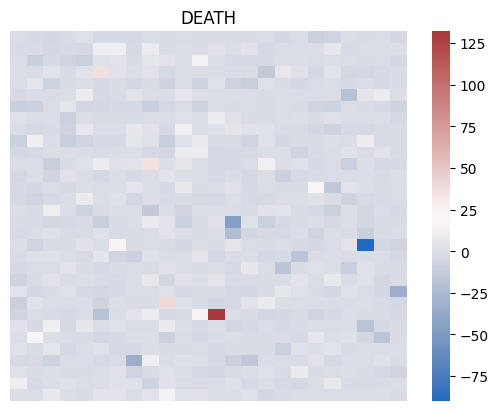

In [40]:
plot_coeff("death")

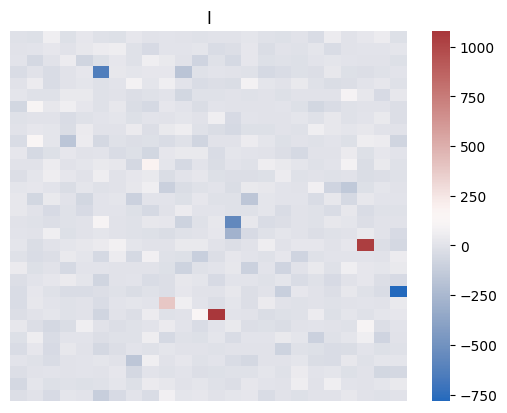

In [41]:
plot_coeff("i")

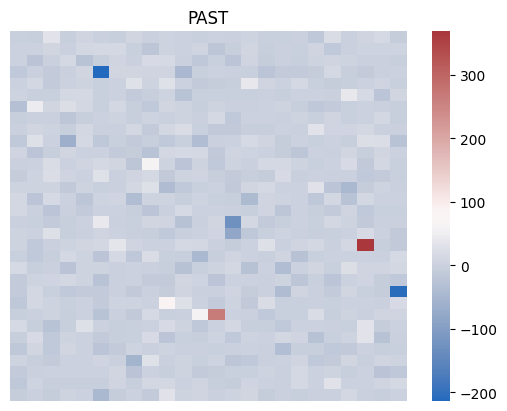

In [42]:
plot_coeff("past")

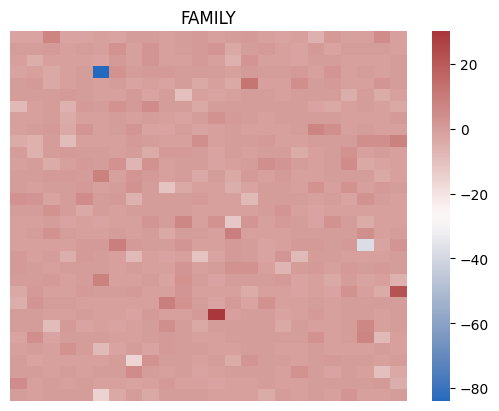

In [43]:
plot_coeff("family")

For well known lexical opposite, coefficient shoud be distant:

checking by element-wise product (smaller is better)

In [44]:
for a, b in [["posemo", "negemo"], ["i", "past"], ["adverb", "negate"]]:
    i = category_names.index(a)
    j = category_names.index(b)
    v = np.multiply(ridge_reg.coef_[i], ridge_reg.coef_[j])
    # v = np.dot(ridge_reg.coef_[i], ridge_reg.coef_[j])
    print(v.max())

4.81028e-19
3.8515654e-17
5.8825235e-18


### Attention

In [45]:
from wordcloud import WordCloud

In [46]:
TEST_0 = "One of the most important things you could realize is that I found me alone"
TEST_1 = x_test.iloc[3]

Extracting attention from CLS to other tokens of the last RoBERTa layer

In [51]:
fine_model = AutoModelForSequenceClassification.from_pretrained("ranieri-unimi/test-trainer").to("cuda")

loading configuration file config.json from cache at C:\Users\martin.ranieri/.cache\huggingface\hub\models--ranieri-unimi--test-trainer\snapshots\b5e2fbae8a0cae7902a826e71a8efd0e776954c1\config.json
Model config RobertaConfig {
  "_name_or_path": "ranieri-unimi/test-trainer",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pyt

In [52]:
def word_prob(text, to_filter=False):
    input_ids = tokenizer_hf.encode(text, return_tensors="pt", padding=True, truncation=True).to("cuda")
    # if input_ids.shape[-1] > 512:
    #     return [], []
    outputs = fine_model(
        input_ids,
        output_attentions=True,
        # attention_mask=attention_mask,
    )
    attention_weights = outputs[-1]
    attention_norms = attention_weights[-1][0, :, :, :].norm(dim=0)
    word_score = attention_norms[0, 1:-1].cpu().detach().numpy()

    word_name = [tokenizer_hf.decode(e).lower().strip() for e in input_ids[0, 1:-1]]

    if to_filter:
        word_score, word_name = list(
            zip(
                *[
                    (word_score[i], word_name[i])
                    for i in range(len(word_name))
                    if len(word_name[i]) > 1 and not word_name[i].startswith("depress")
                ]
            )
        )

    return word_name, word_score


In [53]:
def plot_text_wc(text, score=None):
    wc = WordCloud(
        background_color="white",
        # width=3000,
        # height=2000,
    )
    if score is None:
        wc.generate(text)
    else:
        wc.generate_from_frequencies(dict(zip(text, score)))

    plt.figure()
    plt.imshow(wc)
    plt.axis("off")
    plt.show()


Plottig word cloud were words are weighted by attention

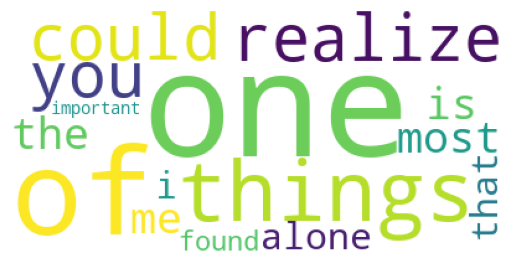

In [54]:
word_name, word_score = word_prob(TEST_0)
plot_text_wc(word_name, word_score)

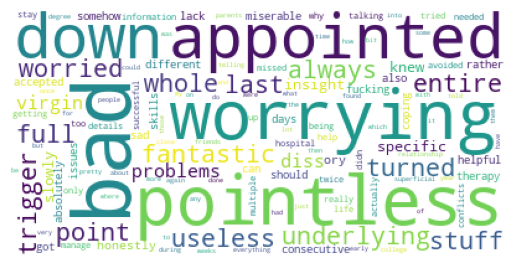

In [55]:
word_name, word_score = word_prob(TEST_1, to_filter=True)
plot_text_wc(word_name, word_score)

Plottig word cloud for False Positive / False Nagative class 

In [56]:
test_fp = [x_test.iloc[i] for i,g in enumerate(w_grp) if g == "FP"]
test_fn = [x_test.iloc[i] for i,g in enumerate(w_grp) if g == "FN"]
test_tp = [x_test.iloc[i] for i,g in enumerate(w_grp) if g == "TP"]
test_tn = [x_test.iloc[i] for i,g in enumerate(w_grp) if g == "TN"]

In [57]:
from nltk.corpus import stopwords
eng_sw = stopwords.words('english')

In [58]:
def retrive_top_k_words(a, how_many):
    bag = []
    for text in tqdm(a):
        word_name, word_score = word_prob(text)
        if len(word_name) < how_many:  # phrase too short
            continue
        for i in np.argpartition(word_score, -how_many)[-how_many:]:
            word = word_name[i]
            if len(word) > 2 and not word.startswith("depress") and not word.startswith("feel") and word != "don" and not word.startswith("anx") and word not in eng_sw:
                bag.append(word)
    return bag

In [59]:
def plot_top_k_words(a, how_many=4):
    bag = retrive_top_k_words(a, how_many)
    f_text = " ".join(bag)
    plot_text_wc(f_text)

In [60]:
test_corpus = {
    group: [x_test.iloc[i] for i, g in enumerate(w_grp) if g == group]
    for group in ("TP", "TN", "FP", "FN")
}


In [61]:
cls_corpus = {
    group : " ".join(retrive_top_k_words(a, 5))
    for group, a in test_corpus.items()
}

100%|██████████| 161/161 [00:04<00:00, 35.71it/s]


In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cls_corpus.values())
vectorizer.get_feature_names_out()

array(['111', '825', 'abandoned', ..., 'yet', 'zac', 'zos'], dtype=object)

In [63]:
tokens = vectorizer.get_feature_names_out()
scores = X.toarray()

In [64]:
for i, g in enumerate(("TP", "TN", "FP", "FN")):
    print("+" * 5, g, "+" * 5)
    tier = sorted(zip(tokens, scores[i, :]), key=lambda x: x[1], reverse=True)
    for k, v in tier[:20]:
        print(k)


+++++ TP +++++
bad
hate
going
want
would
else
need
never
know
ever
like
shit
trying
wrong
could
black
great
last
mean
get
+++++ TN +++++
going
like
know
would
want
bad
always
one
never
shit
else
hate
time
could
think
ever
need
trying
last
mean
+++++ FP +++++
hate
would
going
bad
get
one
want
noticed
pts
til
last
suicidal
episodes
serious
use
went
ago
could
hell
know
+++++ FN +++++
always
bad
going
want
would
americ
official
think
animal
bitch
cartoon
hold
knew
pressure
sometimes
keep
lost
sad
apart
let


Visualizing how attention wordclouds are different between classification groups

100%|██████████| 706/706 [00:22<00:00, 31.78it/s]


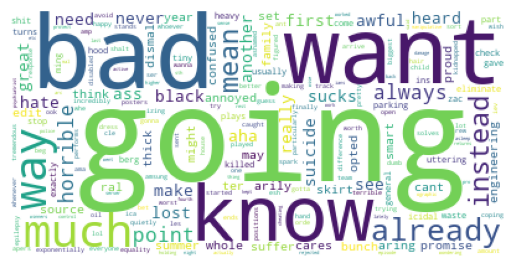

In [65]:
plot_top_k_words(test_tp, how_many=1)

100%|██████████| 146/146 [00:04<00:00, 29.49it/s]


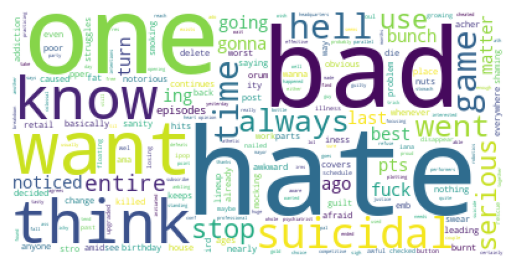

In [66]:
plot_top_k_words(test_fp)

100%|██████████| 161/161 [00:05<00:00, 31.83it/s]


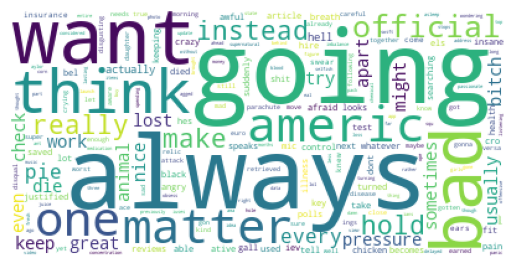

In [67]:
plot_top_k_words(test_fn)

100%|██████████| 752/752 [00:24<00:00, 30.09it/s]


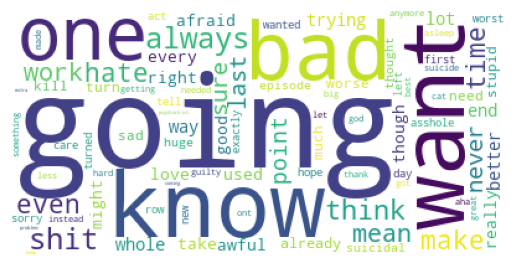

In [68]:
plot_top_k_words(test_tn)

### failed attempts - similarities

In [ ]:
0/0

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial import distance

import plotly.express as px

Here we compute the cosine similiarity between all pairs of document embeddings

In [ ]:
M = len(y_lex)
cosine_mx = np.zeros((M,M))
for i in tqdm(range(M)):
    for j in range(M):
        cosine_mx[i,j] = distance.cosine(y_lex[i], y_lex[j])

We reduce the dimentionality of the embeddings to visualize if missclassification is somehow related to embedding position

In [ ]:
NC = 5

In [ ]:
# X_embedded = TSNE(n_components=NC, learning_rate='auto',
#                   init='random', perplexity=3).fit_transform(cosine_mx)
# X_embedded.shape

In [ ]:
pca = PCA(n_components=NC)
new_coord = pca.fit_transform([e for e,g in zip(cosine_mx,w_grp) if g != "TN"])

In [ ]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    new_coord, # X_embedded,
    labels=labels,
    dimensions=range(NC),
    color=[g for g in w_grp if g != "TN"],
    height=1000,
)
fig.update_traces(diagonal_visible=False)
fig.show()

tf idf

In [ ]:
vect = TfidfVectorizer()
tfidf_mx = vect.fit_transform(x_test)
words = vect.get_feature_names_out()

In [ ]:
# a, b = tfidf_mx.shape
# tiv = np.zeros((a,b))
# for i in tqdm(range(a)):
#     for j in range(b):
#         tiv = tfidf_mx[i,j]